# Zadanie 5

Celem ćwiczenia jest implementacja algorytmu Q-learning.

Następnie należy stworzyć agenta rozwiązującego problem [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/). Problem dostępny jest w pakiecie **gym**.

Punktacja (max 7 pkt):
- Implementacja algorytmu Q-learning. [3 pkt]
- Eksperymenty dla różnych wartości hiperparametrów [2 pkt]
- Jakość kodu [1 pkt]
- Wnioski [1 pkt]


In [ ]:
!pip install gymnasium

In [ ]:
import numpy as np
import gymnasium as gym
import pygame

### QLearningSolver

In [ ]:
class QLearningSolver:
    def __init__(
        self,
        observation_space: int,
        action_space: int,
        learning_rate: float = 0.1,
        gamma: float = 0.9,
        epsilon: float = 0.1,
    ):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon

        self.q_table = np.zeros((self.observation_space, self.action_space))

    def __call__(self, state: int, action: int) -> float:
        return self.q_table[state, action]

    def update(self, state: int, action: int, reward: float) -> None:
        self.q_table[state, action] = reward

    def get_best_action_index(self, state: int) -> int:
        return np.argmax(self.q_table[state, :])

    def get_best_reward(self, state: int) -> float:
        return max(self.q_table[state, :])

    def __repr__(self):
        info = f"QLearningSolver: observation_space: {self.observation_space}, \
            action_space: {self.action_space}\n"
        info2 = f"Learning rate: {self.learning_rate}, gamma: {self.gamma}, epsilon: {self.epsilon}\n"
        return info + info2 + f"Qtable: \n{self.q_table}"

    def __str__(self):
        return self.__repr__()


### Trening i wizualizacja

In [ ]:
def get_trained_q_solver_for_taxi_problem(n_episodes: int, max_iter_per_episode: int,
                                          learning_rate: float = 0.1, gamma: float = 0.9,
                                          epsilon: float = 0.1,) -> QLearningSolver:
    q_solver = QLearningSolver(500, 6, learning_rate, gamma, epsilon)

    env = gym.make('Taxi-v3')
    for _ in range(n_episodes):
        starting_state = env.reset()
        curr_state = starting_state[0]

        if_finished = None
        iters = 0

        while not if_finished and iters <= max_iter_per_episode:
            if np.random.uniform(0, 1) < q_solver.epsilon:
                action = env.action_space.sample()
            else:
                action = q_solver.get_best_action_index(curr_state)

            next_state, reward, if_finished, _, _ = env.step(action)
            lr = q_solver.learning_rate
            new_reward = (1 - lr) * q_solver(curr_state, action) + lr * \
                (reward + q_solver.gamma * q_solver.get_best_reward(next_state))
            q_solver.update(curr_state, action, new_reward)
            curr_state = next_state
            iters += 1

    env.close()
    return q_solver


def show_visualization(*, train_n_episodes: int = 3000, train_max_iter_per_episode: int = 300,
                       max_steps_in_episode: int = 35, ms_delay: int = 100,
                       if_verbose: bool = False) -> None:
    env = gym.make('Taxi-v3', render_mode="human",
                   max_episode_steps=max_steps_in_episode)
    starting_state = env.reset()
    curr_state = starting_state[0]
    q_solver = get_trained_q_solver_for_taxi_problem(train_n_episodes,
                                                     train_max_iter_per_episode)

    if_finished = None
    if_truncated = None
    while not if_finished and not if_truncated:
        env.render()

        action = q_solver.get_best_action_index(curr_state)
        if if_verbose:
            print(f"Best action is: {action}")

        next_state, _, if_finished, if_truncated, info = env.step(action)
        curr_state = next_state

        if if_verbose:
            print("Aktualnie można wykonać akcje: " + str(info['action_mask']))
            print(q_solver)
        pygame.time.delay(ms_delay)

    env.render()
    env.close()


### Przykład wizualiacji (pokazane będzie nie w Colabie)

In [ ]:
show_visualization()

# Eksperymenty

### Kod do przetestowania hiperparametrów

In [ ]:
def test_hyperparameter(hyperparameter_name: str, hyperparameter_values: np.ndarray, *,
                        max_steps_in_episode: int = 50,
                        num_of_tests_per_option: int = 30) -> dict[float, int]:
    env = gym.make('Taxi-v3', max_episode_steps=max_steps_in_episode)

    results = {}
    for value in hyperparameter_values:
        kwargs = {hyperparameter_name: value}
        q_solver = get_trained_q_solver_for_taxi_problem(1_000, 150, **kwargs)

        wins = get_number_of_successes(num_of_tests_per_option, env, q_solver)
        results[value] = wins

    env.close()
    return results


def get_number_of_successes(num_of_tests_per_option: int, env: gym.Env, q_solver: QLearningSolver) -> int:
    wins = 0
    for _ in range(num_of_tests_per_option):
        starting_state = env.reset()
        curr_state = starting_state[0]

        if_finished = None
        if_truncated = None
        while not if_finished and not if_truncated:
            action = q_solver.get_best_action_index(curr_state)
            next_state, _, if_finished, if_truncated, _ = env.step(action)
            curr_state = next_state

            if if_finished:
                wins += 1
    return wins


Poniższe testy zostały przeprowadzone zmieniając jeden parametr na raz zostawiając przy tym inne domyślne ustawienia parametrów

### Epsilon

Prawdopodobieństwo tego, że w trakcie uczenia (budowania tabeli Q-wartości), agent podejmie losową decyzję zamiast najlepszej na podstawie tabeli Q (im większy, tym większa eksploracja)

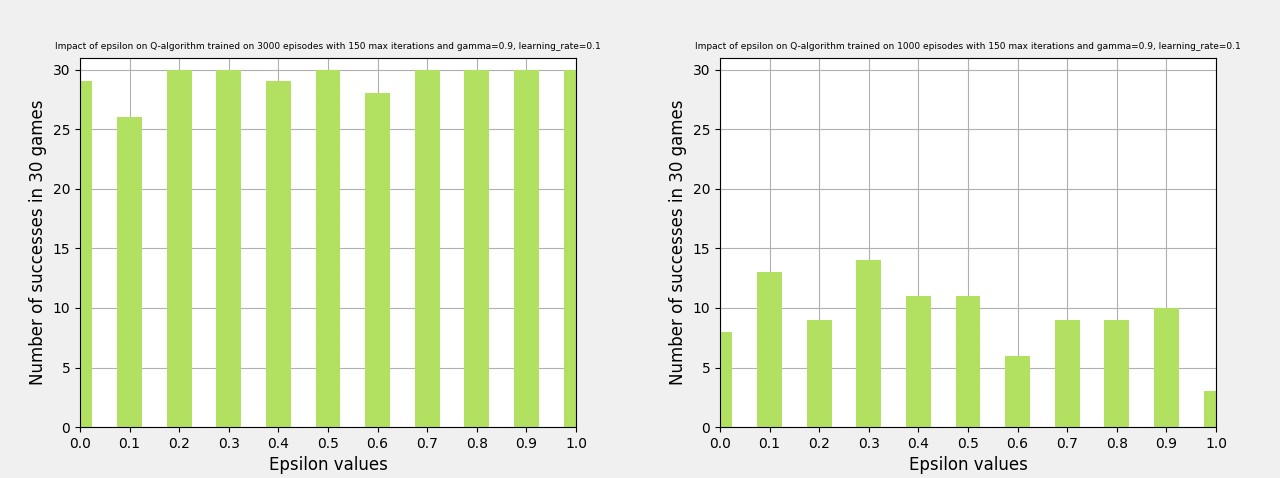

### Wnioski po wykresach epsilona

- wartości mniejsze z zakresu <0.1; 0.5> wydają się być odpowiednie dla epsilona przy mniejszych liczbach epizodów dla tego konkretnego problemu (eksploracja nie może być za wysoka)
- większa liczba epizodów zmniejsza wpływ epsilona na poprawne działanie agenta (rola eksploracji jest mniejsza, bo agent zdobywa więcej informacji o środowisku)
- nawet pełna eksploracja oraz eksploatacja może dać poprawne wyniki przy dużej liczbie epizodów
---
- (hipoteza) prawdopodobnie, najlepszą strategią byłoby stopniowe zmniejszanie epsilona w trakcie uczenia, ponieważ na początku, gdy agent ma małą wiedzę o środowisku, przydałaby się duża eksploracja a później już można bardziej wykorzystywać zgromadzoną wiedzę zmniejszając epsilon

---
### Gamma

Współczynnik dyskontowania, który określa jak bardzo przyszłe nagrody są ważne dla bieżącej decyzji agenta

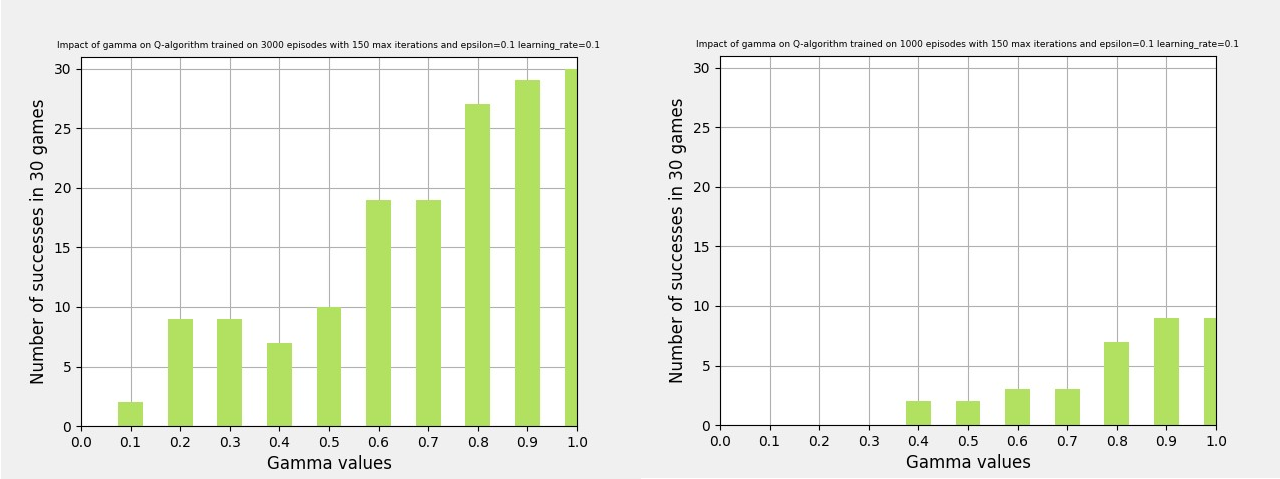


### Wnioski po wykresach gammy

- zarówno przy większych jak i mniejszych wartościach liczby epizodów, wartość gammy z przedziału <0.8; 1> wydaję się być dobrym wyborem dla tego konkretnego problemu
- większa liczba epizodów poprawia wyniki dla każdej wartości gamma
- mniejsze wartości gammy dają gorsze wyniki, ponieważ agent bardziej skupia się na osiągnaniu krótkoterminowych korzyści

---
### Learning rate

Współczynnik uczenia, określa stopień, w jakim nowo uzyskana informacja zastępuje starą wiedzę, regulująć szybkość aktualizacji wartości w tabeli Q wartości

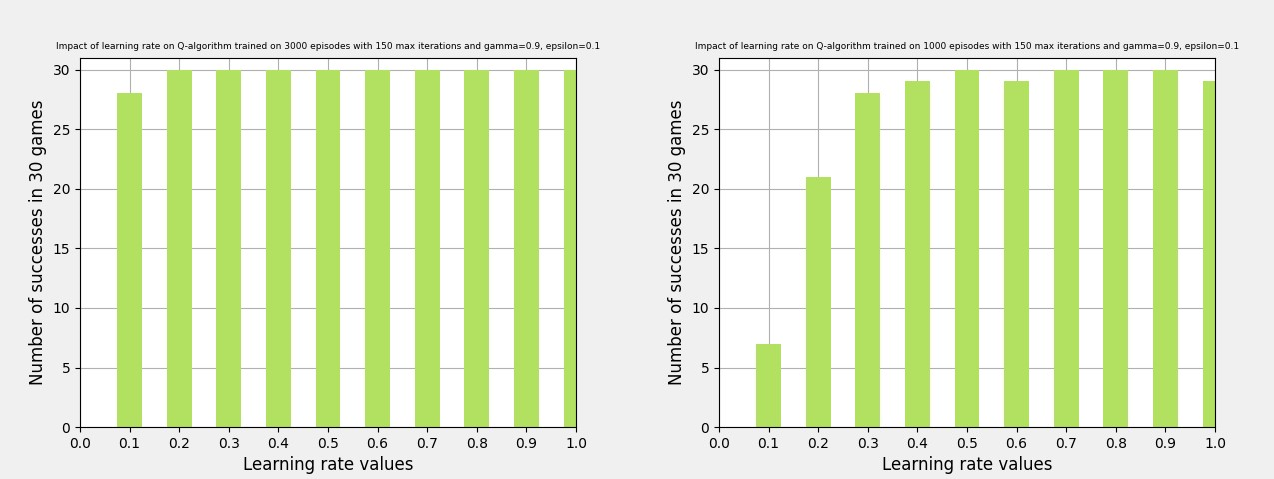

### Wnioski po wykresach dla współczynnika learning rate

- większa liczba epizodów zmniejsza wpływ współczynnika learning rate na poprawne działanie agenta
- jeśli mamy małą liczbę epizodów, to raczej większy współczynnik learning rate będzie lepszy np. >= 0.5 (im niższy learning rate, tym wolniej agent się uczy)

---
### Liczba epizodów w trakcie uczenia się (tworzenia tabeli Q wartości)

Liczba epizodów określa liczbę pełnych cykli interakcji agenta ze środowiskiem, które są wykorzysytwane podczas procesu uczenia się

Kod użyty do przetestowania

In [ ]:
def test_num_of_episodes(*, max_steps_in_episode: int = 50,
                         num_of_tests_per_option: int = 30) -> dict[float, int]:
    env = gym.make('Taxi-v3', max_episode_steps=max_steps_in_episode)
    results = {}
    possible_n_episodes = np.arange(0, 5001, 500)

    for n_episodes in possible_n_episodes:
        q_solver = get_trained_q_solver_for_taxi_problem(n_episodes, 150)

        wins = get_number_of_successes(num_of_tests_per_option, env, q_solver)
        results[n_episodes] = wins

    env.close()
    return results


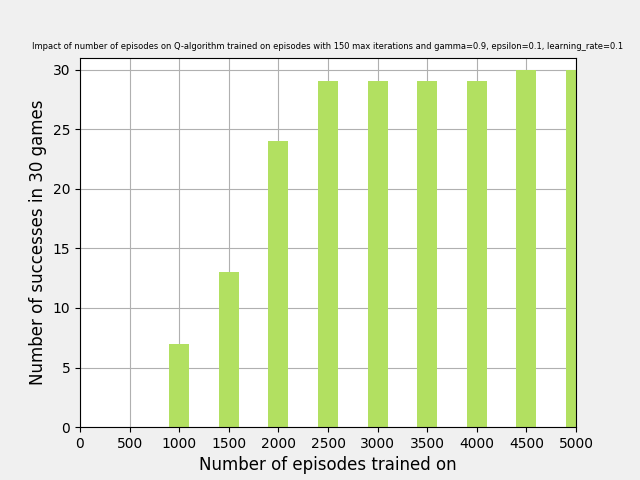

### Wnioski po wykresach dla liczby epizodów w trakcie uczenia się

- im większa liczba epizodów w trakcie uczenia się, tym agent podejmuje lepsze decyzje, ponieważ lepiej zna środowisko

---
### Maksymalna liczba iteracji w trakcie pojedynczego epizodu

Maksymalna liczba iteracji w trakcie pojedynczego epizodu określa limit kroków, które agent może podjąć w jednym epizodzie, zapobiegając nieskończyonym pętlom i wspomagając efektywne uczenie się poprzed ogarniczenie czasu trwania epizodu

Kod użyty do przetestowania

In [ ]:
def test_max_iters_per_episode(*, max_steps_in_episode: int = 50,
                               num_of_tests_per_option: int = 30) -> dict[float, int]:
    env = gym.make('Taxi-v3', max_episode_steps=max_steps_in_episode)
    results = {}
    possible_max_iterations = np.arange(0, 501, 50)

    for max_iters in possible_max_iterations:
        q_solver = get_trained_q_solver_for_taxi_problem(1_000, max_iters)
        wins = get_number_of_successes(num_of_tests_per_option, env, q_solver)
        results[max_iters] = wins

    env.close()
    return results


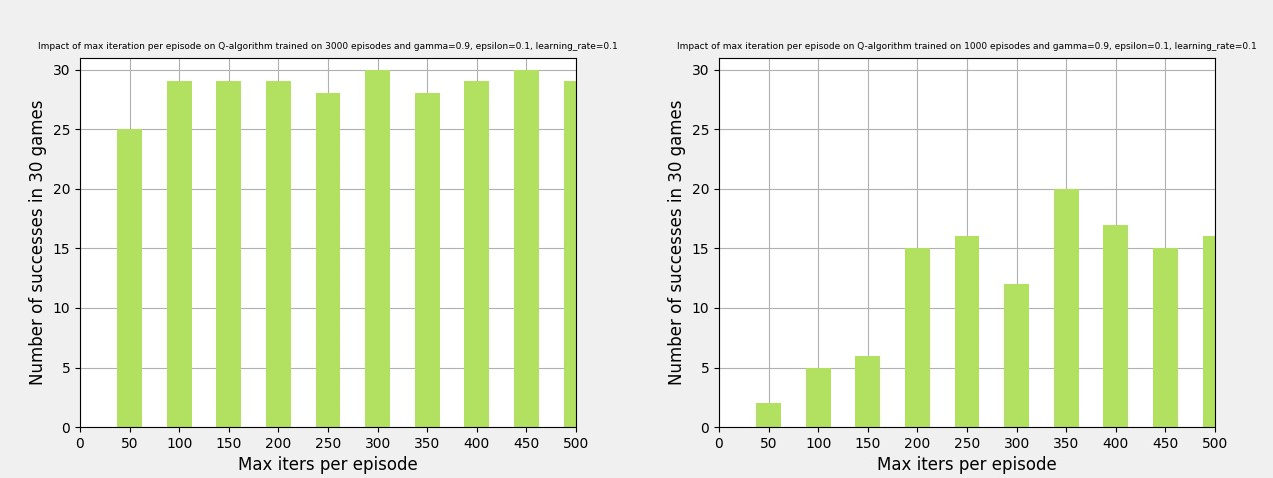

### Wnioski po wykresach maksymalnej liczby iteracji w trakcie pojedynczego epizodu

- większa liczba maksymalnych iteracji może prowadzić do gorszych wyników, ponieważ wtedy za bardzo dostosowujemy się do poszczególnych stanów
- ale jeśli damy za małą liczbę maksymalnych iteracji, to agent może nie mieć wystarczajaco dużo czasu na zbadanie różnych stanów
- trzeba znaleźć optymalną liczbę maksymalnych iteracji w epizodzie dla konkretnego problemu
- większa liczba epizodów zmniejsza wpływ maksymalnej liczby iteracji w epizodzie na poprawne działanie agenta
---